<a href="https://colab.research.google.com/github/Gilberto-Gonzalez/uruqai-multirisk-logistics-platform/blob/main/Air_qualyty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset**

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Calidad_del_aire_Emisiones de contaminantes.csv to Calidad_del_aire_Emisiones de contaminantes.csv


**Inspect The Dataset**

In [8]:
import pandas as pd

df = pd.read_csv('Calidad_del_aire_Emisiones de contaminantes.csv', encoding='utf-8')

# Quick overview
df.head()
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10521 entries, 0 to 10520
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Entidad_federativa  10521 non-null  object 
 1   Municipio           10521 non-null  object 
 2   Tipo_de_Fuente      10521 non-null  object 
 3   SO_2                8068 non-null   float64
 4   CO                  8068 non-null   float64
 5   NOx                 10521 non-null  float64
 6   COV                 10521 non-null  float64
 7   PM_010              8068 non-null   float64
 8   PM_2_5              8068 non-null   float64
 9   NH_3                8068 non-null   float64
 10  Entidad             10521 non-null  object 
dtypes: float64(7), object(4)
memory usage: 904.3+ KB


,Entidad_federativa,Municipio,Tipo_de_Fuente,SO_2,CO,NOx,COV,PM_010,PM_2_5,NH_3,Entidad
count,10521,10521,10521,8068.000000,8068.000000,10521.000000,10521.000000,8068.000000,8068.000000,8068.000000,10521
unique,32,2320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
top,Oaxaca,Benito Juárez,Fuentes de área,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oaxaca
freq,2300,30,2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300
mean,NaN,NaN,NaN,167.177163,979.171072,301.863359,1032.544628,107.645949,70.792638,107.651188,NaN
std,NaN,NaN,NaN,3776.416470,4539.641567,1418.744688,4513.871267,471.985604,284.731018,537.788480,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,0.136000,3.492750,5.291000,2.065000,0.333000,0.302750,0.003000,NaN
50%,NaN,NaN,NaN,0.771500,84.121500,38.719000,76.857000,5.178000,4.351500,0.346000,NaN
75%,NaN,NaN,NaN,3.693250,584.397750,194.401000,658.433000,54.314250,38.406000,32.400250,NaN


**There’s no date or year**
Then your dataset is cross-sectional, not time series.

**A. Distribution of pollutants**

Columns: ['Entidad_federativa', 'Municipio', 'Tipo_de_Fuente', 'SO_2', 'CO', 'NOx', 'COV', 'PM_010', 'PM_2_5', 'NH_3', 'Entidad']
[Info] Using 'Tipo_de_Fuente' as the pollutant/category column (auto-selected).
[Info] Using 'CO' as the concentration/value column (auto-selected).
Detected columns: 
  pollutant/category -> Tipo_de_Fuente 
  concentration/value -> CO


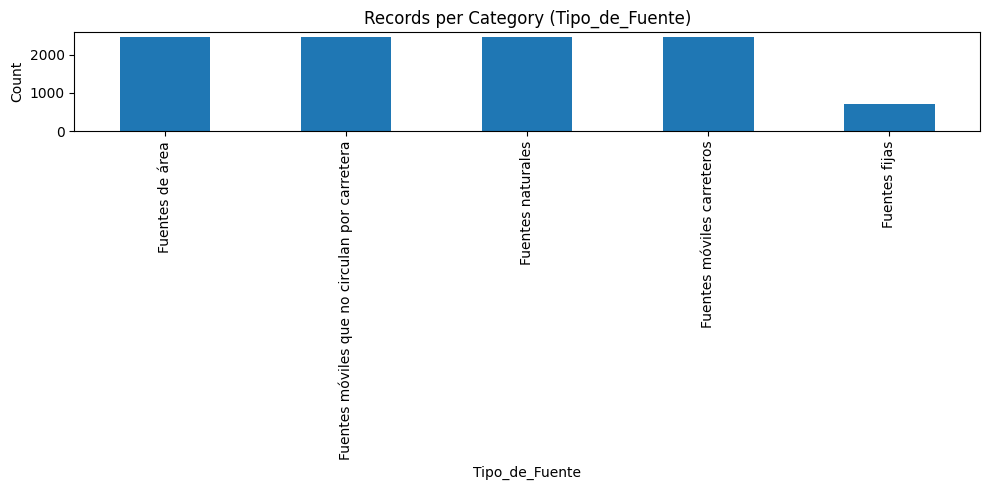

Top absolute correlations:


In [19]:
# === Auto-detect columns & run A/B analyses even if names differ ===
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Show columns so you can see what's inside
print("Columns:", df.columns.tolist())

# Helper: normalize names (lowercase, no accents)
def norm(s):
    s = s.lower()
    s = (s.replace("á","a").replace("é","e").replace("í","i")
            .replace("ó","o").replace("ú","u").replace("ñ","n"))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

cols_norm = {c: norm(c) for c in df.columns}

# 1) Try to find a POLLUTANT name column (string/categorical)
pollutant_keys = [
    "contaminante","pollutant","parametro","especie","sustancia","compuesto",
    "componente","gas","material particulado","mp", "pm", "no2","so2","o3"
]
pollutant_col = None
for c, cn in cols_norm.items():
    if any(k in cn for k in pollutant_keys) and df[c].dtype == 'object':
        pollutant_col = c
        break

# If not found, pick a reasonable categorical column (3–50 uniques)
if pollutant_col is None:
    cat_candidates = []
    for c in df.columns:
        # treat object or category as categorical candidates
        if df[c].dtype == 'object' or str(df[c].dtype).startswith('category'):
            nunique = df[c].nunique(dropna=True)
            if 3 <= nunique <= 50:
                cat_candidates.append((c, nunique))
    # Choose the one with “most balanced” cardinality (closest to 12)
    if cat_candidates:
        pollutant_col = sorted(cat_candidates, key=lambda x: abs(x[1]-12))[0][0]
        print(f"[Info] Using '{pollutant_col}' as the pollutant/category column (auto-selected).")
    else:
        print("[Warn] Could not find a categorical column to act as pollutant.")
        pollutant_col = None

# 2) Find a CONCENTRATION-like numeric column
conc_keys = [
    "concentracion","concentration","valor","value","medicion","measurement",
    "nivel","nivel medio","promedio","mean","media","ppb","ppm","ug/m3","μg/m3"
]
concentration_col = None
# First pass: by name
for c, cn in cols_norm.items():
    if any(k in cn for k in conc_keys):
        # Try coercion to numeric if not already numeric
        ser = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors='coerce')
        if ser.notna().mean() > 0.5:  # at least half numeric
            df[c + "__num"] = ser
            concentration_col = c + "__num"
            break

# Second pass: pick a numeric column with variance (if name-based failed)
if concentration_col is None:
    numeric = df.select_dtypes(include=[np.number])
    if numeric.shape[1] == 0:
        # Try coercing object columns to numeric (last resort)
        coerced = {}
        for c in df.columns:
            ser = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors='coerce')
            if ser.notna().mean() > 0.5:
                coerced[c + "__num"] = ser
        if coerced:
            for k,v in coerced.items():
                df[k] = v
            numeric = df[list(coerced.keys())]

    if numeric.shape[1] > 0:
        # choose the column with highest std (avoid IDs)
        stats = numeric.std().sort_values(ascending=False)
        if len(stats) > 0:
            concentration_col = stats.index[0]
            print(f"[Info] Using '{concentration_col}' as the concentration/value column (auto-selected).")
    else:
        print("[Warn] No numeric column detected for concentration.")
        concentration_col = None

print("Detected columns:",
      "\n  pollutant/category ->", pollutant_col,
      "\n  concentration/value ->", concentration_col)

# ============== ANALYSIS A: Distribution by pollutant/category ==============
if pollutant_col is not None:
    plt.figure(figsize=(10,5))
    df[pollutant_col].value_counts().head(20).plot(kind='bar')
    plt.title(f'Records per Category ({pollutant_col})')
    plt.xlabel(pollutant_col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("[Skip] Distribution plot: no suitable categorical column found.")


# Optional: show top correlations between numeric fields (if any)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    print("Top absolute correlations:")
    (corr.where(~np.eye(corr.shape[0], dtype=bool))
         .abs().stack().sort_values(ascending=False).head(10))
else:
    print("[Info] Not enough numeric columns for correlation matrix.")


**B. Average concentration per pollutant**

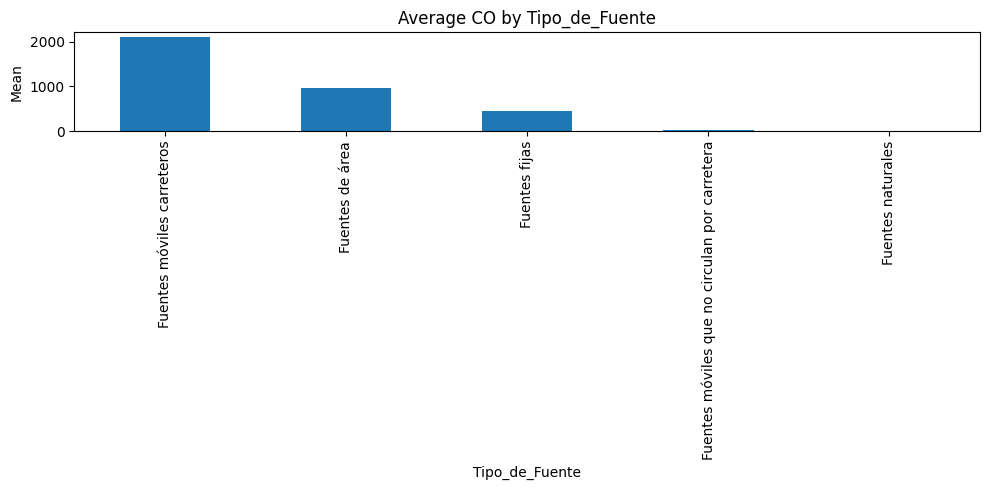

,CO
Tipo_de_Fuente,
Fuentes móviles carreteros,2103.498976
Fuentes de área,967.139460
Fuentes fijas,440.592216
Fuentes móviles que no circulan por carretera,24.306317
Fuentes naturales,NaN


In [18]:
# This assumes you've already run the auto-detect cell I gave you.
# It defines: pollutant_col (categorical) and concentration_col (numeric)

if pollutant_col is None or concentration_col is None:
    raise ValueError("We need both a categorical column (pollutant_col) and a numeric column (concentration_col). Re-run the auto-detect cell and check the 'Detected columns' printout.")

grp = (df.groupby(pollutant_col)[concentration_col]
         .mean()
         .sort_values(ascending=False)
         .head(20))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
grp.plot(kind='bar')
plt.title(f'Average {concentration_col} by {pollutant_col}')
plt.ylabel('Mean')
plt.tight_layout()
plt.show()

grp



**C.Regional analysis (if you have “Municipio”, “Provincia”, or “Region”)**

Columns: ['Entidad_federativa', 'Municipio', 'Tipo_de_Fuente', 'SO_2', 'CO', 'NOx', 'COV', 'PM_010', 'PM_2_5', 'NH_3', 'Entidad']
[✔] Detected region column: Municipio
[ℹ] Using first numeric column: SO_2


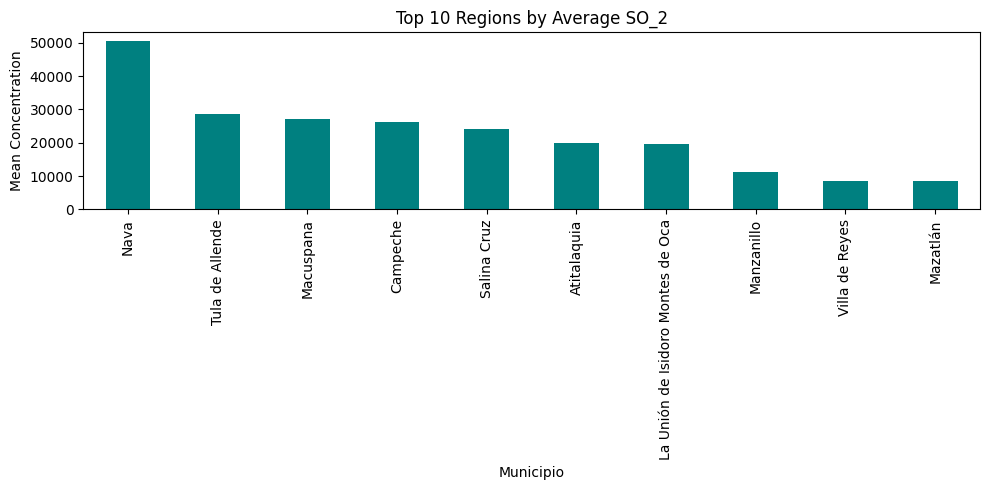

Top 10 Regions:
 Municipio
Nava                                 50598.66525
Tula de Allende                      28535.91850
Macuspana                            27112.24050
Campeche                             26345.18750
Salina Cruz                          24270.96850
Atitalaquia                          19913.31125
La Unión de Isidoro Montes de Oca    19693.76100
Manzanillo                           11347.62825
Villa de Reyes                        8627.73225
Mazatlán                              8517.81700
Name: SO_2, dtype: float64


In [21]:
# ==== Auto-detect region/location + numeric column and plot ====
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Columns:", df.columns.tolist())

# Normalize column names for easier matching
def norm(s):
    return re.sub(r'\s+', ' ', s.lower()
                  .replace("á","a").replace("é","e").replace("í","i")
                  .replace("ó","o").replace("ú","u").replace("ñ","n")).strip()

cols_norm = {c: norm(c) for c in df.columns}

# 1 Find region / city / location-like column
location_keys = [
    "municipio","localidad","region","provincia","ciudad","zona",
    "area","departamento","comunidad","distrito","estacion"
]
region_col = None
for c, cn in cols_norm.items():
    if any(k in cn for k in location_keys):
        region_col = c
        break

if region_col:
    print(f"[✔] Detected region column: {region_col}")
else:
    print("[⚠] Could not find region/municipality column automatically.")
    print("Pick one manually from:", df.columns.tolist())

# 2️ Find a concentration/value-like numeric column (reuse from before if exists)
conc_candidates = [c for c in df.columns if re.search(r'concen|valor|value|mean|media|ppm|ppb|ug|μg', norm(c))]
concentration_col = None

for c in conc_candidates:
    ser = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors='coerce')
    if ser.notna().mean() > 0.5:
        df[c + "__num"] = ser
        concentration_col = c + "__num"
        break

if concentration_col:
    print(f"[✔] Detected numeric column: {concentration_col}")
else:
    # Fallback: use any numeric column
    numeric = df.select_dtypes(include=np.number)
    if not numeric.empty:
        concentration_col = numeric.columns[0]
        print(f"[ℹ] Using first numeric column: {concentration_col}")
    else:
        print("[X] No numeric column found.")
        raise ValueError("Cannot plot without numeric data.")

# 3️ Plot top 10 by region
if region_col and concentration_col:
    grp = (df.groupby(region_col)[concentration_col]
             .mean().sort_values(ascending=False).head(10))

    plt.figure(figsize=(10,5))
    grp.plot(kind='bar', color='teal')
    plt.title(f'Top 10 Regions by Average {concentration_col}')
    plt.ylabel('Mean Concentration')
    plt.tight_layout()
    plt.show()

    print("Top 10 Regions:\n", grp)
else:
    print("[Skip] Missing region_col or concentration_col — can't plot.")


**D. Correlation between pollutants**

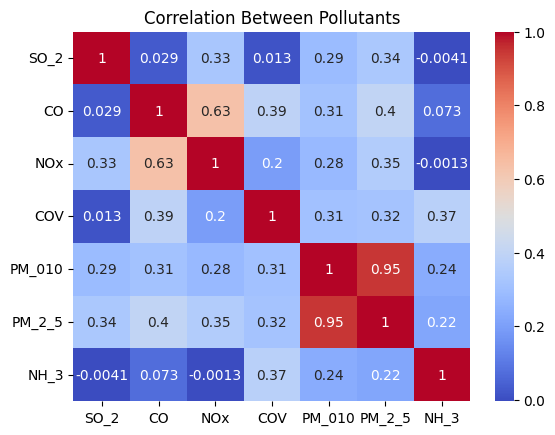

In [22]:
import seaborn as sns

num_df = df.select_dtypes(include='number')
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutants')
plt.show()
